In [91]:
from pathlib import Path
import numpy as np
import laspy
import open3d as o3d
import hdbscan
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [92]:
VOXEL = 0.20
GROUND_CLASS = [0, 1, 2] # ground, lowveg etc, not trees
DATA_DIR = Path("../data/")

GT_name = "treeID" # ground truth label 

In [93]:
def load_xyz_cls_gt(path):
    las = laspy.read(str(path))
    xyz = np.column_stack((las.x, las.y, las.z)).astype(np.float64)

    cls = None # label for each point. ground, low veg, etc
    if "classification" in las.point_format.dimension_names:
        cls = np.asarray(las.classification).astype(np.int32)

    # ground truth
    gt = np.asarray(getattr(las, GT_name)).astype(np.int64)
    return xyz, cls, gt

def remove_ground_mask(cls):
    # idxs without ground
    return ~np.isin(cls, np.asarray(GROUND_CLASS, dtype=cls.dtype))


def voxel_subsample_with_trace(xyz, gt):
    pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(xyz))

    # voxelize, idxs is index of original points in each voxel
    _, _, idxs = pcd.voxel_down_sample_and_trace(
        voxel_size=VOXEL,
        min_bound=pcd.get_min_bound(),
        max_bound=pcd.get_max_bound(),
    )
    # select representative index for each voxel
    rep = np.array([i[0] for i in idxs if len(i) > 0], dtype=np.int64)
    return xyz[rep], gt[rep], rep




In [94]:
def show_clusters(xyz, labels):
    labels = np.asarray(labels)

    # non-noise points only
    mask = labels >= 0 
    xyz_f = xyz[mask]
    labels_f = labels[mask]

    # random color for each cluster
    colors = np.zeros((labels_f.size, 3))
    rng = np.random.default_rng(0)
    uniq = np.unique(labels_f)
    lut = {l: rng.random(3) for l in uniq}
    colors[:] = np.array([lut[l] for l in labels_f])

    p = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(xyz_f))
    p.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([p]) # open3d window, matplotlib for figures later... 


In [ ]:
def compute_scores(gt, pred):
    # m is 0 for noise, 1 for non-noise, 
    # mean becomes fraction of points actually clustered
    m = pred >= 0
    coverage = float(m.mean())

    gt_eval = gt[m]
    pred_eval = pred[m]
    
    ari = adjusted_rand_score(gt_eval, pred_eval)
    ami = adjusted_mutual_info_score(gt_eval, pred_eval)
    
    n_pred_clusters = int(np.unique(pred_eval).size)

    return {
        "coverage": coverage,
        "ARI": float(ari),
        "AMI": float(ami),
        "n_pred_clusters": n_pred_clusters,
    }



def run_hdbscan(xyz, params):
    # scale z
    X = xyz.astype(np.float64).copy()
    X[:, 2] *= params["z_scale"]

    
    model = hdbscan.HDBSCAN(
        min_cluster_size=params["min_cluster_size"],
        min_samples=params["min_samples"],
        metric=params["metric"],
        cluster_selection_method=params["cluster_selection_method"],
        cluster_selection_epsilon=params["cluster_selection_epsilon"],
        prediction_data=False,
        core_dist_n_jobs=-1,
    )
    
    # run hdbscan
    labels = model.fit_predict(X)
    return labels, model

In [ ]:
def evaluate_single_dataset(paths, params):
    rows = []
    for rel in paths: 
        p = (DATA_DIR / rel).resolve()

        # load points, their labels and ground trurth instance ids
        xyz, cls, gt = load_xyz_cls_gt(p)

        # remove ground and low veg
        keep = remove_ground_mask(cls)
        xyz = xyz[keep]
        gt = gt[keep]

        # keep only tree points
        m_gt = gt > 0
        xyz = xyz[m_gt]
        gt = gt[m_gt]

        # voxel downsample, same transform for ground truth
        xyz, gt, _ = voxel_subsample_with_trace(xyz, gt)

        # run and compute scores
        pred, model = run_hdbscan(xyz, params)
        scores = compute_scores(gt, pred)

        # per-file info
        row = {
            "n_points_eval": int(len(gt)), # total points
            "n_gt_instances": int(np.unique(gt).size), # total ground turth clusters
            "n_pred_clusters": int(scores["n_pred_clusters"]), # predicted clusters
            "coverage": float(scores["coverage"]),
            "ARI": float(scores["ARI"]),
            "AMI": float(scores["AMI"]),
            
            # for plots
            "xyz" : xyz,
            "gt" : gt,
            "pred" : pred,
        }

        

        rows.append(row)

    # totals for all files
    gt_all = np.concatenate([r["gt"][r["pred"] >= 0] for r in rows])
    pred_all = np.concatenate([r["pred"][r["pred"] >= 0] for r in rows])


    total_ari = adjusted_rand_score(gt_all, pred_all)
    total_ami = adjusted_mutual_info_score(gt_all, pred_all)
    total_cov = float(np.mean([(r["pred"] >= 0).mean() for r in rows]))

    summary = {
        "total_ARI": float(total_ari),
        "total_AMI": float(total_ami), 
        "total_coverage": float(total_cov),
    }

    return rows, summary


def print_dataset_summary(name, summary):
    print(f"{name}:")
    print(f"ARI {100*summary['total_ARI']:>8.1f}%")
    print(f"AMI {100*summary['total_AMI']:>8.1f}%")
    print(f"Cov {100*summary['total_coverage']:>8.1f}%")
    print()


In [97]:
CULS_dev = ["CULS/plot_1_annotated.las"]

CULS_params = {
    "z_scale": 0.20,
    "min_cluster_size": 500,
    "min_samples": 50,
    "metric": "euclidean",
    "cluster_selection_method": "leaf",
    "cluster_selection_epsilon": 0.0,
}

c_rows, c_summary = evaluate_single_dataset(CULS_dev, CULS_params)
print_dataset_summary("CULS", c_summary)
# show_clusters(c_rows[0]["xyz"], c_rows[0]["pred"])

CULS:
ARI    100.0%
AMI    100.0%
Cov    100.0%



In [98]:
NIBIO_dev = ["NIBIO/plot_10_annotated.las"]#, "NIBIO/plot_11_annotated.las"]
NIBIO_params = {
    "z_scale": 0.20,
    "min_cluster_size": 400,
    "min_samples": 25,
    "metric": "euclidean",
    "cluster_selection_method": "leaf",
    "cluster_selection_epsilon": 0.0,
}

n_rows, n_summary = evaluate_single_dataset(NIBIO_dev, NIBIO_params)
print_dataset_summary("NIBIO", n_summary)
# show_clusters(n_rows[0]["xyz"], n_rows[0]["pred"])

NIBIO:
ARI     94.1%
AMI     95.2%
Cov     14.1%



In [99]:
RMIT_dev = ["RMIT/TRAIN.las",]
RMIT_params = {
    "z_scale": 0.20,
    "min_cluster_size": 350,
    "min_samples": 25,
    "metric": "euclidean",
    "cluster_selection_method": "leaf",
    "cluster_selection_epsilon": 0.0,
}

r_rows, r_summary = evaluate_single_dataset(RMIT_dev, RMIT_params)
print_dataset_summary("RMIT", r_summary)
# show_clusters(r_rows[0]["xyz"], r_rows[0]["pred"])

RMIT:
ARI     80.0%
AMI     93.2%
Cov     54.2%



In [100]:
SCION_dev = ["SCION/plot_35_annotated.las",]
SCION_params = {
    "z_scale": 0.10,
    "min_cluster_size": 200,
    "min_samples": 50,
    "metric": "euclidean",
    "cluster_selection_method": "leaf",
    "cluster_selection_epsilon": 0.0,
}

s_rows, s_summary = evaluate_single_dataset(SCION_dev, SCION_params)
print_dataset_summary("SCION", s_summary)
# show_clusters(s_rows[0]["xyz"], s_rows[0]["pred"])

SCION:
ARI     80.3%
AMI     88.5%
Cov     17.4%



In [101]:
TUWIEN_dev = ["TUWIEN/train.las",]
TUWIEN_params = {
    "z_scale": 0.20,
    "min_cluster_size": 3500,
    "min_samples": 100,
    "metric": "euclidean",
    "cluster_selection_method": "leaf",
    "cluster_selection_epsilon": 0.0,
}
t_rows, t_summary = evaluate_single_dataset(TUWIEN_dev, TUWIEN_params)
print_dataset_summary("TUWIEN", t_summary)

TUWIEN:
ARI     61.2%
AMI     87.0%
Cov     38.2%



In [102]:
# show_clusters(t_rows[0]["xyz"], t_rows[0]["pred"])

In [103]:
################## TEST ########################
CULS_test = ["CULS/plot_2_annotated.las"]
NIBIO_test = [
        "NIBIO/plot_1_annotated.las",
        "NIBIO/plot_17_annotated.las",
        "NIBIO/plot_18_annotated.las",
        "NIBIO/plot_22_annotated.las",
        "NIBIO/plot_23_annotated.las",
        "NIBIO/plot_5_annotated.las",
]
RMIT_test = ["RMIT/test.las"]
SCION_test = [
        "SCION/plot_31_annotated.las",
        "SCION/plot_61_annotated.las"
]
TUWIEN_test = ["TUWIEN/test.las"]




ct_rows, ct_summary = evaluate_single_dataset(CULS_test, CULS_params)
print_dataset_summary("CULS test", ct_summary)

nt_rows, nt_summary = evaluate_single_dataset(NIBIO_test, NIBIO_params)
print_dataset_summary("NIBIO test", nt_summary)

rt_rows, rt_summary = evaluate_single_dataset(RMIT_test, RMIT_params)
print_dataset_summary("RMIT test", rt_summary)

st_rows, st_summary = evaluate_single_dataset(SCION_test, SCION_params)
print_dataset_summary("SCION test", st_summary)

tt_rows, tt_summary = evaluate_single_dataset(TUWIEN_test, TUWIEN_params)
print_dataset_summary("TUWIEN test", tt_summary)





CULS test:
ARI     99.5%
AMI     99.4%
Cov     69.0%

NIBIO test:
ARI     31.8%
AMI     58.5%
Cov     21.7%

RMIT test:
ARI     61.4%
AMI     87.0%
Cov     57.3%

SCION test:
ARI     65.1%
AMI     81.0%
Cov     23.2%

TUWIEN test:
ARI     89.9%
AMI     88.5%
Cov     30.7%



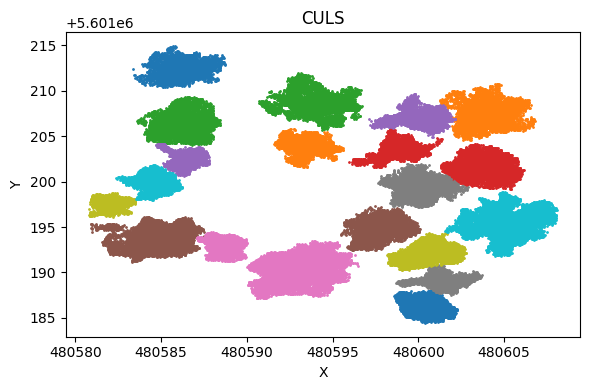

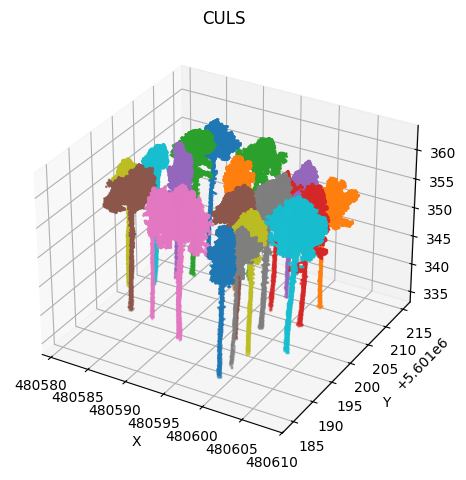

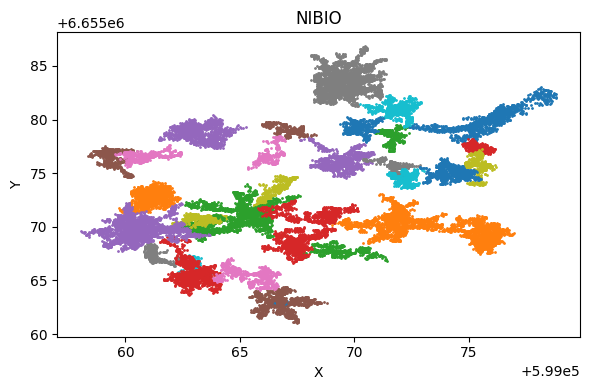

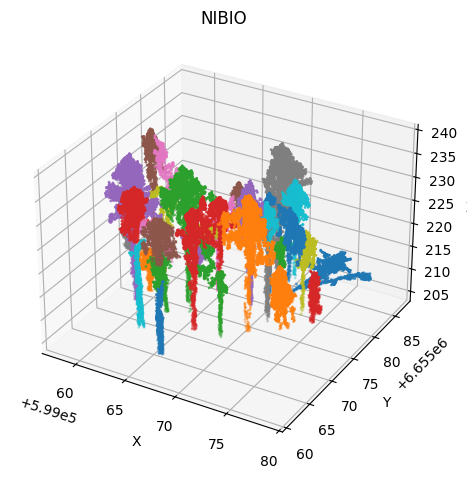

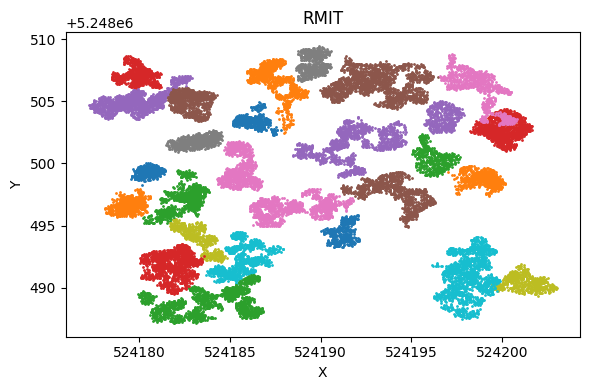

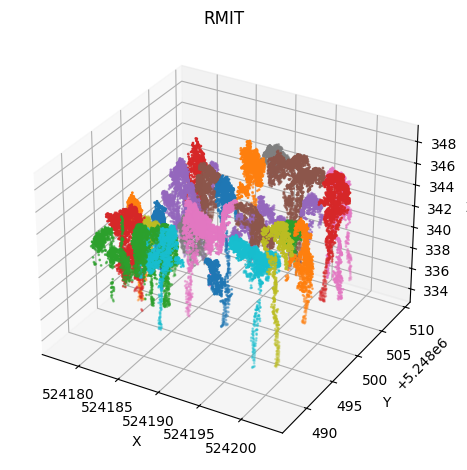

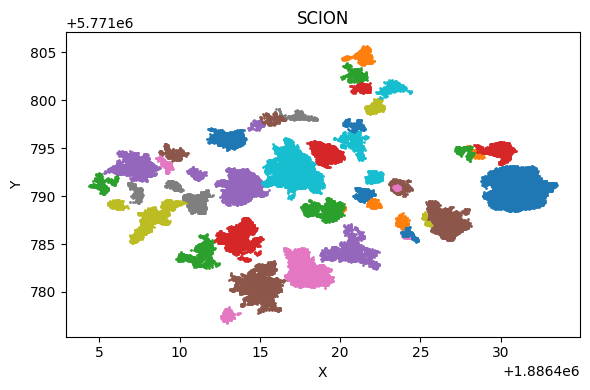

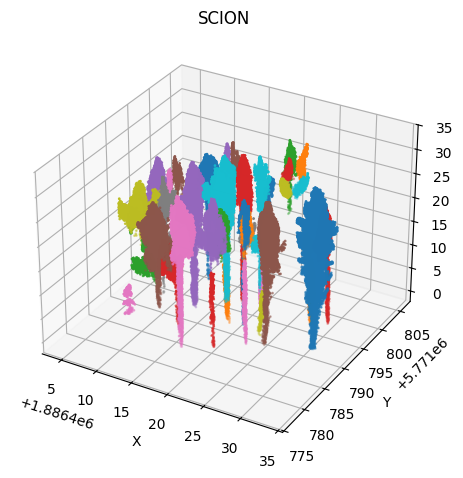

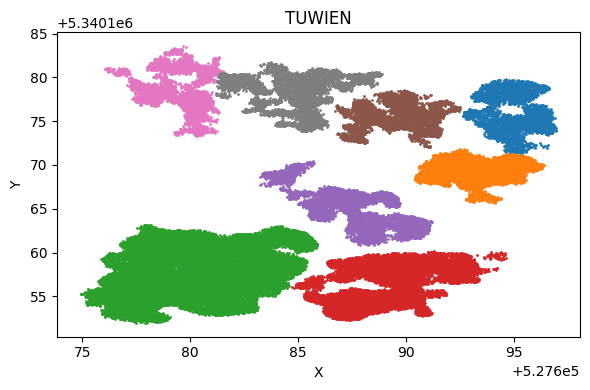

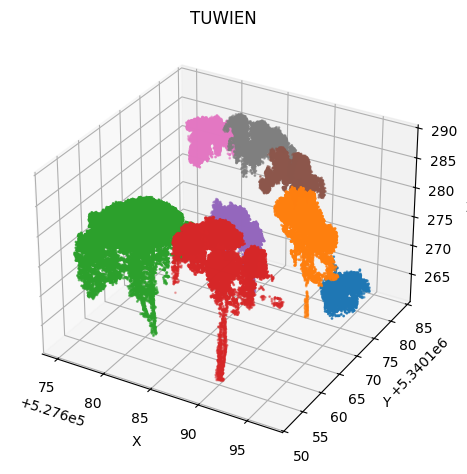

In [ ]:
def plot_one(rows, title):
    r = rows[0]
    xyz = r["xyz"]
    labels = r["pred"]

    m = labels >= 0
    xyz = xyz[m]
    labels = labels[m]

    # XY
    plt.figure(figsize=(6,4))
    for lab in np.unique(labels):
        pts = xyz[labels == lab]
        plt.scatter(pts[:, 0], pts[:, 1], s=1)
    plt.title(f"{title}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    # plt.savefig(f"../imgs/{title}_2d.png", dpi=300)
    plt.show()

    # XYZ
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    for lab in np.unique(labels):
        pts = xyz[labels == lab]
        ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=1)
    ax.set_title(f"{title}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.tight_layout()
    # plt.savefig(f"../imgs/{title}_3d.png", dpi=300)
    plt.show()

plot_one(ct_rows, "CULS")
plot_one(nt_rows, "NIBIO")
plot_one(rt_rows, "RMIT")
plot_one(st_rows, "SCION")
plot_one(tt_rows, "TUWIEN")

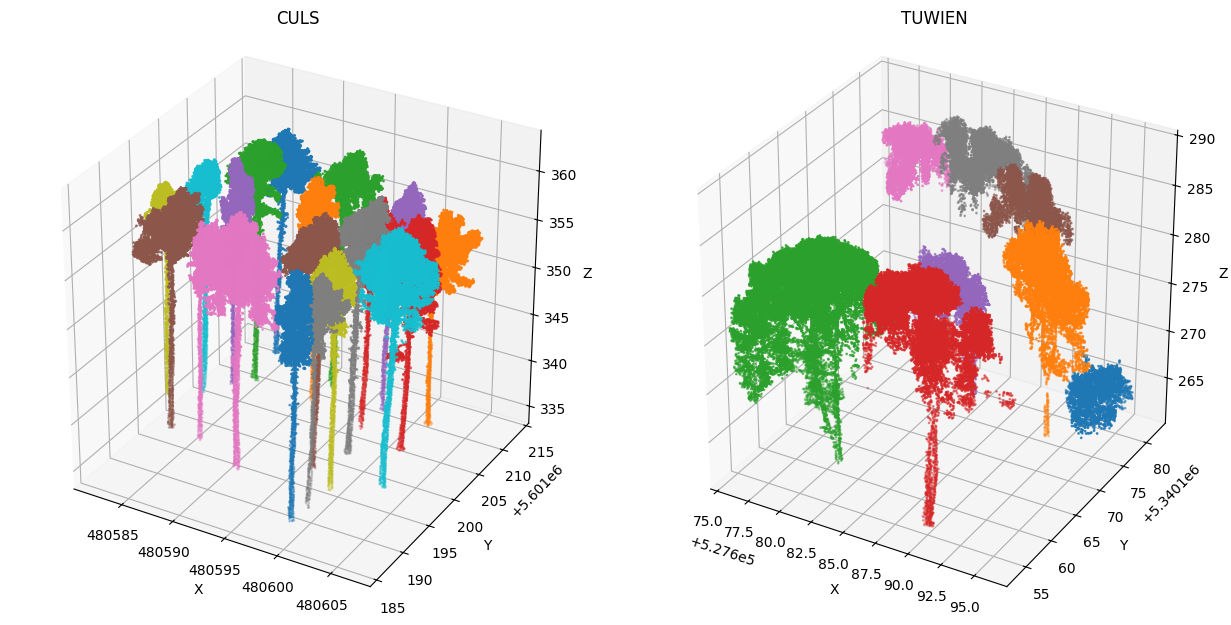

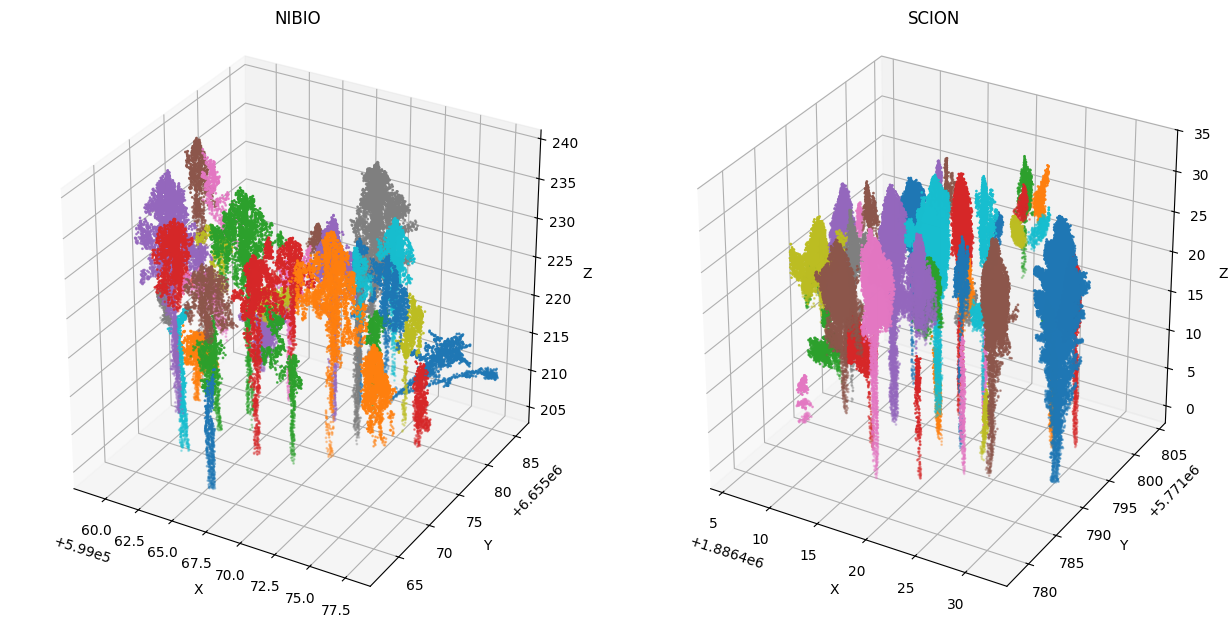

In [ ]:
def plot_pair(rows_a, name_a, rows_b, name_b):
    ra = rows_a[0]
    rb = rows_b[0]

    xa, la = ra["xyz"], ra["pred"]
    xb, lb = rb["xyz"], rb["pred"]

    ma = la >= 0
    mb = lb >= 0

    xa, la = xa[ma], la[ma]
    xb, lb = xb[mb], lb[mb]

    fig = plt.figure(figsize=(14, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")

    ax1.set_box_aspect([1,1,1]) # less white space
    ax1.margins(0)

    for lab in np.unique(la):
        pts = xa[la == lab]
        ax1.scatter(pts[:,0], pts[:,1], pts[:,2], s=1)
    ax1.set_title(name_a)

    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    ax2 = fig.add_subplot(1, 2, 2, projection="3d")

    ax2.set_box_aspect([1,1,1]) # less white space
    ax2.margins(0)

    for lab in np.unique(lb):
        pts = xb[lb == lab]
        ax2.scatter(pts[:,0], pts[:,1], pts[:,2], s=1)
    ax2.set_title(name_b)

    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")

    fig.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.92, wspace=0.02) # less white space
    plt.tight_layout(pad=0.1)
    # plt.savefig(f"../imgs/{name_a}_{name_b}_3d.png", dpi=300)
    plt.show()

plot_pair(ct_rows, "CULS", tt_rows, "TUWIEN")
plot_pair(nt_rows, "NIBIO", st_rows, "SCION")

In [119]:
global_ARI = (ct_summary['total_ARI'] + 5*nt_summary['total_ARI'] + rt_summary['total_ARI'] + 2*st_summary['total_ARI'] + tt_summary['total_ARI']) / 10
global_AMI = (ct_summary['total_AMI'] + 5*nt_summary['total_AMI'] + rt_summary['total_AMI'] + 2*st_summary['total_AMI'] + tt_summary['total_AMI']) / 10
global_COV = (ct_summary['total_coverage'] + 5*nt_summary['total_coverage'] + rt_summary['total_coverage'] + 2*st_summary['total_coverage'] + tt_summary['total_coverage']) / 10


print("GLOBAL MEAN:")
print(f"ARI {100*global_ARI:>8.1f}%")
print(f"AMI {100*global_AMI:>8.1f}%")
print(f"Cov {100*global_COV:>8.1f}%")

GLOBAL MEAN:
ARI     54.0%
AMI     72.9%
Cov     31.2%
